In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os
from datetime import datetime
from datetime import timedelta

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
print(parent_dir)
dbpath = f"{parent_dir}/Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{dbpath}")
print(dbpath)

/Users/galenmittermann/Documents/GitHub/sqlalchemy-challenge
/Users/galenmittermann/Documents/GitHub/sqlalchemy-challenge/Resources/hawaii.sqlite


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Taking a look at the top rows in station table (and making sure that my query works)
result = session.execute('SELECT * FROM station LIMIT 5')
for row in result:
    print(row)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


In [10]:
# Taking a look at the top rows in measurement table
result = session.execute('SELECT * FROM measurement LIMIT 5')
for row in result:
    print(row)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [11]:
# Seeing what the inspect module will do, and the format, so I can refer to it later
from sqlalchemy.inspection import inspect
inspect(engine).get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [12]:
columns = inspect(measurement).columns
for column in columns:
    print(column.name)

id
station
date
prcp
tobs


In [13]:
# Look at the min and max dates in the measurement table and see what type they are if i read them
date_range = session.execute('select min(date), max(date) from measurement')
for row in date_range:
    min_date = row[0]
    max_date = row[1]
    print(min_date, max_date)
    print(type(min_date), type(max_date))

2010-01-01 2017-08-23
<class 'str'> <class 'str'>


# Exploratory Precipitation Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# I will get the most recent date and then take one year away to get the bottom of my date range
max_date_query = session.execute('SELECT MAX(date) FROM measurement')
for row in max_date_query:
    max_date_string = row[0]
    print(max_date_string)


# Calculate the date one year from the last date in data set.

max_date = datetime.strptime(max_date_string, '%Y-%m-%d').date()
one_year_ago = max_date - timedelta(days=365)
print(one_year_ago)

# double checking my date types
print(type(max_date), type(one_year_ago))


# Perform a query to retrieve the data and precipitation scores

# pass one year ago value into query to filter by date
query = 'select date, prcp from measurement where date >= :one_year_ago'
test_data_query = session.execute(query, {'one_year_ago':one_year_ago})

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# put this query result into a dataframe. column names are set as i am using a dict to create this
dict_prcp = []
for row in test_data_query:
    dict_prcp.append({'date': row[0], 'precipitation': row[1]})

df_prcp = pd.DataFrame(dict_prcp)
df_prcp.head()

2017-08-23
2016-08-23
<class 'datetime.date'> <class 'datetime.date'>


,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [15]:
# Sort the dataframe by date
df_prcp.sort_values('date', ascending=True)

,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


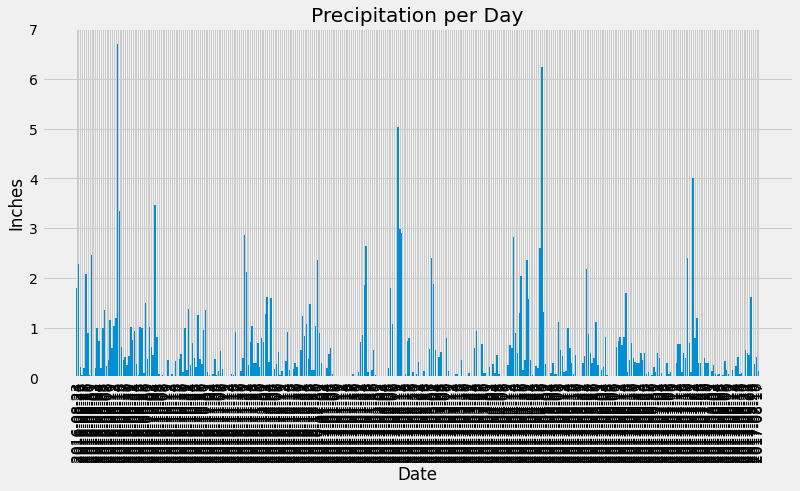

In [16]:

# Use Pandas Plotting with Matplotlib to plot the data


# create the bar chart for precipitation by day
fig, ax = plt.subplots(figsize=(12,6))
# plot bar chart
ax.bar(df_prcp['date'], df_prcp['precipitation'])
# set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.set_title('Precipitation per Day')

# rotate x-axis labels for readability
plt.xticks(rotation=90)

# display chart
plt.show()


In [17]:
df_prcp['date'] = pd.to_datetime(df_prcp['date'])
df_prcp['date'][0]

Timestamp('2016-08-23 00:00:00')

In [18]:
# Now I resample the data to group by week, because the daily means don't tell much of a story

df_prcp_weekly = df_prcp.resample('W', on='date').mean()
df_prcp_weekly.head()

,precipitation
date,
2016-08-28,0.447222
2016-09-04,0.206486
2016-09-11,0.209459
2016-09-18,0.638000
2016-09-25,0.134091


In [19]:
# need to reset the index because we can see above that it replaced with the date
df_prcp_weekly = df_prcp_weekly.reset_index()

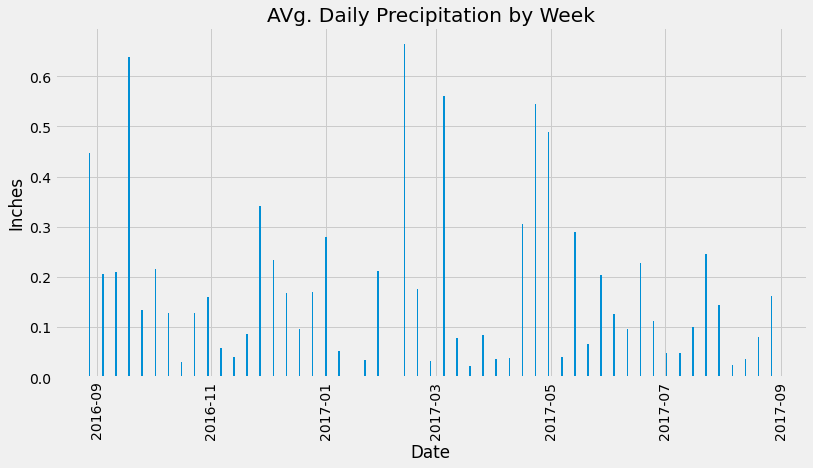

In [20]:
# now doing the bar chart by weekly grouping on the weekly dataframe
fig, ax = plt.subplots(figsize=(12,6))

# plot bar chart of weekly precipitation
ax.bar(df_prcp_weekly['date'], df_prcp_weekly['precipitation'])

# set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.set_title('AVg. Daily Precipitation by Week')

# rotate x-axis labels for readability
plt.xticks(rotation=90)

# display chart
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data

# here i do it for the grouped weekly dataframe
df_prcp_weekly.describe()

,date,precipitation
count,53,53.000000
mean,2017-02-26 00:00:00,0.172511
min,2016-08-28 00:00:00,0.000588
25%,2016-11-27 00:00:00,0.048857
50%,2017-02-26 00:00:00,0.127027
75%,2017-05-28 00:00:00,0.215227
max,2017-08-27 00:00:00,0.664348
std,NaN,0.163983


In [22]:
# here i do summary statistics for the whole dataset (not grouped by week)

df_prcp.describe()

,date,precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [23]:
# inspect columns in station table to keep it on top for reading

columns = inspect(station).columns
for column in columns:
    print(column.name)

id
station
name
latitude
longitude
elevation


In [24]:
# inspect columns in measurement table to keep it on top for reading

columns = inspect(measurement).columns
for column in columns:
    print(column.name)

id
station
date
prcp
tobs


In [25]:
# Design a query to calculate the total number of stations in the dataset

tot_stations = session.execute('select count(id) from station')
for row in tot_stations:
    print(row)

(9,)


In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

result = session.execute('select station, count(id) as count_id from measurement group by station order by count_id desc')
result_list = []
for row in result:
    print(row) # printing to make sure it worked
    result_list.append(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [27]:
# save the most active station name for use in the detailed station analysis below

most_active_station_name = result_list[0][0]
print('The station with the greatest number of observations is: ', most_active_station_name)

The station with the greatest number of observations is:  USC00519281


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# I am re-using the format that worked for me previously with the ':' format to parameterize the query
query = 'select station, min(tobs), max(tobs), avg(tobs) from measurement where station = :most_active_station_name'
most_active_data_query = session.execute(query, {'most_active_station_name':most_active_station_name})
most_active_data = []
for row in most_active_data_query:
    most_active_data.append(row)
print(most_active_data)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station

query = 'select date, tobs from measurement where station = :most_active_station_name'
most_active_data_query_hist = session.execute(query, {'most_active_station_name':most_active_station_name})
most_active_data_dict = [] # I will write the data to a dictionary that makes it easy to conver to dataframe
for row in most_active_data_query_hist:
    most_active_data_dict.append({'date': row[0], 'tobs': row[1]})



In [30]:
# Make the dataframe for the most active station
df_most_active = pd.DataFrame(most_active_data_dict)
df_most_active.head()

,date,tobs
0,2010-01-01,70.0
1,2010-01-02,62.0
2,2010-01-03,74.0
3,2010-01-04,75.0
4,2010-01-05,74.0


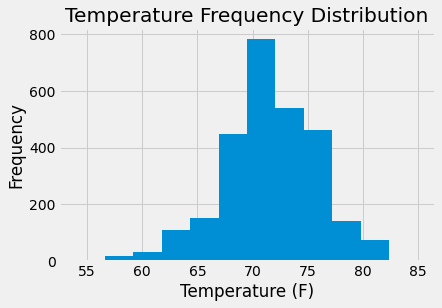

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# histogram with bins = 12 as requested

df_most_active['tobs'].plot.hist(bins=12)

# set the x and y axis labels and title
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Frequency Distribution')

# display the histogram
plt.show()

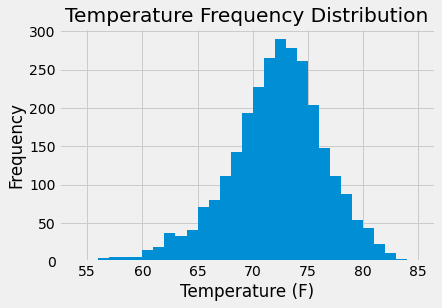

In [32]:

# alternative plot - looking at what it looks like with a more narrow bin range
# setting the bins: 1 degree buckets, starting at the lowest observed temp and going to the highest
bins = []
for i in range(int(most_active_data[0][1]), int(most_active_data[0][2])+1,1):
    bins.append(i)
df_most_active['tobs'].plot.hist(bins=bins)

# set the x and y axis labels and title
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Frequency Distribution')

# display the histogram
plt.show()

# Close Session

In [33]:
# Close Session
session.close()